In [1]:
%matplotlib inline
import fnmatch
import os
import pandas as pd
from tqdm import tqdm

matches = []
for root, dirnames, filenames in os.walk('.'):
    for filename in fnmatch.filter(filenames, '*.txt'):
        matches.append(os.path.join(root, filename))

In [2]:
def parse_fname(fname, df):
    fname = os.path.basename(fname)
    fn = os.path.splitext(fname)[0]
    d = dict(zip(('name', 'motive', 'col', 'type'), fn.split(' - ')))
    
    for key, val in d.items():
        df[key] = val
    df['file'] = fname

In [3]:
df = pd.DataFrame()
for f in tqdm(matches):
    data = pd.read_csv(f, sep='\t')
    parse_fname(f,data)
    df = df.append(data, ignore_index=True)
df.drop(['Start Time [ms]','End Time [ms]','Unnamed: 15'], axis=1, inplace=True)

100%|██████████| 2/2 [00:00<00:00, 162.85it/s]


Average fixation [ms]  Fixation count
col motive    type Area of Interest                                        
sw  candy all kpi  candy 12                             0.0               0
                   candy 2                              0.0               0
                   candy 11                             0.0               0
                   candy 10                             0.0               0
                   candy 1                              0.0               0
                   partiziell 2020                      0.0               0
                   White Space                          0.0               0
                   candy 7                            165.7               1
                   Motiv HG                           182.6               2
                   candy 9                            188.1               3
                   ausserhalb                         231.9               1
                   candy 3                            423.3               2
                   Gebissmotivlollis                  447.9               2
                   Monitor HG                         531.0               1
                   candy 4                            564.3               1
                   Gebissmotivlolli                   630.4               1
                   candy 5                            857.1              20
                   candy 8                            858.9              10
                   candy 6                           1659.6               6

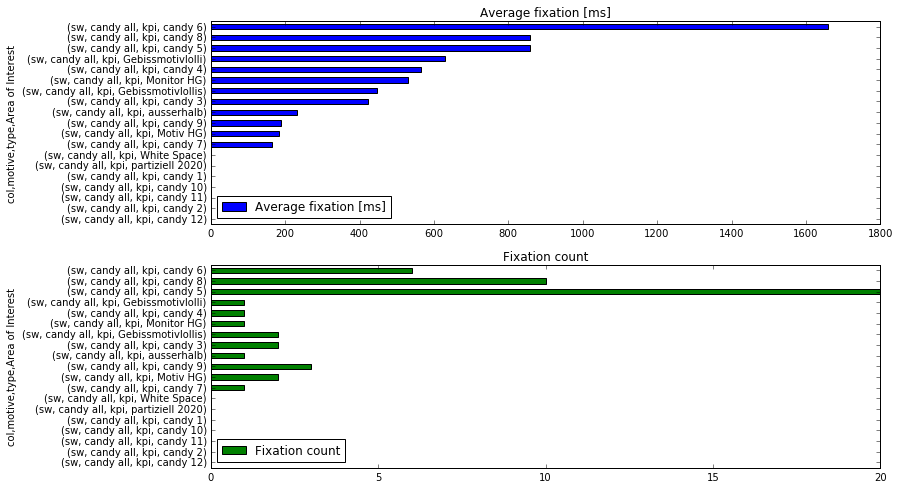

In [4]:
df1 = df[['col','motive','type','Area of Interest', 'Average fixation [ms]', 'Fixation count']]
group = df1.groupby(['col','motive','type','Area of Interest']).sum()
group.sort_values('Average fixation [ms]',inplace=True)
ax = group.plot(kind='barh', figsize=(12,8),subplots=True,sharex=False)
group

In [6]:
#write things to excel
writer = pd.ExcelWriter('output.xlsx')
df1.to_excel(writer,'Data')
group.to_excel(writer,'Groups')
writer.save()